# SEEPS threshold calc

In [24]:
import os
import sys
import yaml
from glob import glob
from datetime import datetime, timedelta

import numpy as np
import xarray as xr
import pandas as pd

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

In [26]:
sys.path.insert(0, os.path.realpath('../libs/'))
import verif_utils as vu
import seeps_utils as seeps

In [27]:
config_name = os.path.realpath('verif_config.yml')

with open(config_name, 'r') as stream:
    conf = yaml.safe_load(stream)

In [31]:
# ---------------------------------------------------------------------------------------- #
# ERA5 verif target
filename_ERA5 = sorted(glob(conf['ERA5_ours']['save_loc']))

# pick years
year_range = [1990, 1991]
years_pick = np.arange(year_range[0], year_range[1]+1, 1).astype(str)
filename_ERA5 = [fn for fn in filename_ERA5 if any(year in fn for year in years_pick)]

# merge yearly ERA5 as one
ds_ERA5 = [vu.get_forward_data(fn) for fn in filename_ERA5]
ds_ERA5_merge = xr.concat(ds_ERA5, dim='time')

variable_levels = {
    'total_precipitation': None,
}

ds_target = ds_ERA5_merge
ds_target = vu.ds_subset_everything(ds_target, variable_levels)
ds_target_24h = ds_target.resample(time='24h').sum()

In [33]:
thres_calc = seeps.SEEPSThreshold(dry_threshold_mm=0.25, var='total_precipitation')
ds_clim = thres_calc.compute(ds_target_24h, dim='time')

save_name = conf['ERA5_weatherbench']['save_loc_clim'] + 'ERA5_clim_1990_2019_SEEPS.nc'
# ds_clim.to_netcdf(save_name, mode='w')

In [21]:
ds_clim = xr.open_dataset(
    '/glade/campaign/cisl/aiml/ksha/CREDIT_physics/VERIF/ERA5_clim/ERA5_clim_1990_2019_SEEPS.nc'
)

In [22]:
thers = ds_clim['total_precipitation_seeps_threshold'].values

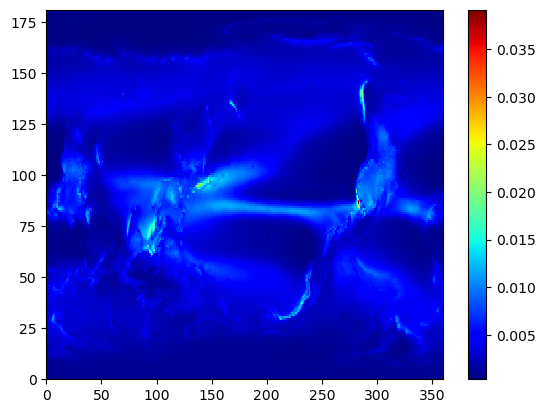

In [23]:
plt.pcolormesh(thers, cmap=plt.cm.jet)
plt.colorbar()

In [57]:
SpatialSEEPS(climatology=thres)

SpatialSEEPS()

In [ ]:


# Compute for the given forecast and truth datasets
seeps_score = seeps_calc.compute_chunk(forecast_ds, truth_ds)

In [37]:
thres

<xarray.Dataset>
Dimensions:                                 (latitude: 181, longitude: 360)
Coordinates:
  * latitude                                (latitude) float32 90.0 ... -90.0
  * longitude                               (longitude) float32 0.0 ... 359.0
Data variables:
    total_precipitation_seeps_threshold     (latitude, longitude) float64 dask.array<chunksize=(181, 360), meta=np.ndarray>
    total_precipitation_seeps_dry_fraction  (latitude, longitude) float64 dask.array<chunksize=(181, 360), meta=np.ndarray>

In [49]:
import functools
import typing as t
import dataclasses
from typing import Callable, Optional, Union, Sequence

In [56]:
@dataclasses.dataclass
class Region:
    """
    Region selector for spatially averaged metrics.
    .apply() method is called before spatial averaging in the Metrics classes.
    Region selection can be either applied as an operation on the dataset itself
    or a weights dataset, typically the latitude weights. The latter option is
    required to implement non-box regions without the use of .where() which would
    clash with skipna=False used as default in the metrics. The way this is
    implemented is by multiplying the input weights with a boolean weight dataset.
    
    Since sometimes the dataset and sometimes the weights are modified, these must
    be used together, most likely insice the _spatial_average function defined in
    metrics.py.
    """

    def apply(
      self, dataset: xr.Dataset, weights: xr.DataArray
    ) -> tuple[xr.Dataset, xr.DataArray]:
        
        """Apply region selection to dataset and/or weights.
        
        Args:
          dataset: Spatial metric, i.e. RMSE
          weights: Weights dataset, i.e. latitude weights
        
        Returns:
          dataset: Potentially modified (sliced) dataset.
          weights: Potentially modified weights data array, to be used in
          combination with dataset, e.g. in _spatial_average().
        """
        raise NotImplementedError

@dataclasses.dataclass
class Metric:
    """Base class for metrics."""

    def compute_chunk(
      self,
      forecast: xr.Dataset,
      truth: xr.Dataset,
      region: t.Optional[Region] = None,
      skipna: bool = False,
    ) -> xr.Dataset:
        
        """Evaluate this metric on a temporal chunk of data.
        
        The metric should be evaluated independently for each time (averaging over
        time is performed later, on multiple chunks). Thus `forecast` and `truth`
        chunks should cover the full spatial extent of the data, but not necessarily
        all times.
        
        Args:
          forecast: dataset of forecasts to evaluate.
          truth: dataset of ground truth. Should have the same variables as
            forecast.
          region: Region class. .apply() method is called inside before spatial
            averaging.
          skipna: Whether to skip NaN values in both forecasts and observations
            during evaluation.
        
        Returns:
          Dataset with metric results for each variable in forecasts/truth, without
          spatial dimensions (latitude/longitude).
        """
        raise NotImplementedError

    def compute(
      self,
      forecast: xr.Dataset,
      truth: xr.Dataset,
      region: t.Optional[Region] = None,
      skipna: bool = False,
    ) -> xr.Dataset:
        """Evaluate this metric on datasets with full temporal coverages."""
        if "time" in forecast.dims:
          avg_dim = "time"
        elif "init_time" in forecast.dims:
          avg_dim = "init_time"
        else:
          raise ValueError(
              f"Forecast has neither valid_time or init_time dimension {forecast}"
          )
        return self.compute_chunk(
            forecast, truth, region=region, skipna=skipna
        ).mean(
            avg_dim,
            skipna=skipna,
        )

class SpatialSEEPS(Metric):
    """Computes Stable Equitable Error in Probability Space.
    
    Definition in Rodwell et al. (2010):
    https://www.ecmwf.int/en/elibrary/76205-new-equitable-score-suitable-verifying-precipitation-nwp
    
    Attributes:
    climatology: climatology dataset containing seeps_threshold [meters] and
      seeps_dry_fraction [0-1] for given precip_name.
    dry_threshold_mm: Dry threhsold in mm, same as used to compute
      climatological values.
    precip_name: Name of precipitation variable, e.g. total_precipitation_24hr.
    min_p1: Mask out values with smaller average dry fraction.
    max_p1: Mask out values with larger average dry fraction.
    p1: Average dry fraction.
    """
    def __init__(
        self,
        climatology: xr.Dataset,
        dry_threshold_mm: float = 0.25,
        precip_name: str = "total_precipitation_24hr",
        min_p1: float = 0.1,
        max_p1: float = 0.85
    ):
        # Initialize the base Metric class without extra arguments
        super().__init__()

    @functools.cached_property
    def p1(self) -> xr.DataArray:
        dry_fraction = self.climatology[f"{self.precip_name}_seeps_dry_fraction"]
        return dry_fraction.mean(("hour", "dayofyear")).compute()

    def _convert_precip_to_seeps_cat(self, ds):
        """Helper function for SEEPS computation. Converts values to categories."""
        wet_threshold = self.climatology[f"{self.precip_name}_seeps_threshold"]
        # Convert to SI units [meters]
        dry_threshold = self.dry_threshold_mm / 1000.0
        da = ds[self.precip_name]
        wet_threshold_for_valid_time = wet_threshold.sel(
            dayofyear=da.valid_time.dt.dayofyear, hour=da.valid_time.dt.hour
        ).load()

        dry = da < dry_threshold
        light = np.logical_and(
            da > dry_threshold, da < wet_threshold_for_valid_time
        )
        heavy = da >= wet_threshold_for_valid_time
        result = xr.concat(
            [dry, light, heavy],
            dim=xr.DataArray(["dry", "light", "heavy"], dims=["seeps_cat"]),
        )
        # Convert NaNs back to NaNs
        result = result.astype("int").where(da.notnull())
        return result

    def compute_chunk(
        self,
        forecast: xr.Dataset,
        truth: xr.Dataset,
        region: t.Optional[Region] = None,
        skipna: bool = False,
    ) -> xr.Dataset:
        del skipna  # Ignored, must be effectively True because of p1 mask.
        forecast_cat = self._convert_precip_to_seeps_cat(forecast)
        truth_cat = self._convert_precip_to_seeps_cat(truth)

        # Compute contingency table
        out = (
            forecast_cat.rename({"seeps_cat": "forecast_cat"})
            * truth_cat.rename({"seeps_cat": "truth_cat"})
        ).compute()
        
        # Compute scoring matrix
        scoring_matrix = [
            [xr.zeros_like(self.p1), 1 / (1 - self.p1), 4 / (1 - self.p1)],
            [1 / self.p1, xr.zeros_like(self.p1), 3 / (1 - self.p1)],
            [
                1 / self.p1 + 3 / (2 + self.p1),
                3 / (2 + self.p1),
                xr.zeros_like(self.p1),
            ],
        ]
        das = []
        for mat in scoring_matrix:
          das.append(xr.concat(mat, dim=out.truth_cat))
        scoring_matrix = 0.5 * xr.concat(das, dim=out.forecast_cat)
        scoring_matrix = scoring_matrix.compute()
        
        # Take dot product
        result = xr.dot(out, scoring_matrix, dims=("forecast_cat", "truth_cat"))
        
        # Mask out p1 thresholds
        result = result.where(self.p1 < self.max_p1, np.nan)
        result = result.where(self.p1 > self.min_p1, np.nan)
        return xr.Dataset({f"{self.precip_name}": result})

In [23]:
ds_target_24h

<xarray.Dataset>
Dimensions:              (latitude: 181, longitude: 360, time: 1097)
Coordinates:
  * latitude             (latitude) float32 90.0 89.0 88.0 ... -88.0 -89.0 -90.0
  * longitude            (longitude) float32 0.0 1.0 2.0 ... 357.0 358.0 359.0
  * time                 (time) datetime64[ns] 2020-01-01 ... 2023-01-01
Data variables:
    total_precipitation  (time, latitude, longitude) float32 dask.array<chunksize=(1, 181, 360), meta=np.ndarray>

In [21]:
# Initialize with a dry threshold of 1 mm
threshold_calculator = SEEPSThreshold(dry_threshold_mm=0.25, var='precip')

# Compute over the 'time' dimension
result = threshold_calculator.compute(ds, dim='time')

print(result)

<xarray.Dataset>
Dimensions:                    (lat: 2, lon: 2)
Coordinates:
  * lat                        (lat) int64 0 1
  * lon                        (lon) int64 0 1
Data variables:
    precip_seeps_threshold     (lat, lon) float64 0.001571 0.00175 ... 0.00185
    precip_seeps_dry_fraction  (lat, lon) float64 0.8 0.6 0.4 0.3
